![STScI Logo](../../../_static/stsci_header.png)

<a id="top"></a>

# Downloading WFC3 and WFPC2 PSF Cutouts from MAST

<hr>

## Learning Goals
This notebook demonstrates how to download PSF cutouts (i.e. "realizations" of the PSF) from the WFC3 and WFPC2 PSF Databases on the MAST Portal using the MAST API. By the end of this tutorial, you will:

- Query the database for source metadata.
- Download source cutouts from reconstructed dataURIs.
- Extract source cutouts from dataURLs.

Acronyms:
- Hubble Space Telescope (HST)
- Wide Field Camera 3 (WFC3)
- Wide Field and Planetary Camera 2 (WFPC2)
- WFC3 Ultraviolet and VISable detector (WFC3/UVIS or UVIS)
- WFC3 InfraRed detector (WFC3/IR or IR)
- Point Spread Function (PSF)
- Mikulski Archive for Space Telescopes (MAST)
- Application Programming Interface (API)

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Query the WFC3 and WFPC2 PSF Databases](#query) <br>
[3. Reconstruct dataURIs](#reconstruct) <br>
[4. Download and extract cutouts using dataURIs](#download) <br>
- [4.1 Single file](#single) <br>
- [4.2 Multiple files: bundle](#bundle) <br>
- [4.3 Multiple files: pooling](#pool) <br>

[5. Extracting cutouts using dataURLs](#url) <br>
[6. Load and plot cutouts](#plot) <br>
[7. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction

The WFC3 and WFPC2 PSF Databases are three databases (WFC3/UVIS, WFC3/IR, and WFPC2) of sources measured in every external observation from the instruments, excluding proprietary data. All sources were measured using [HST1PASS](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2022/WFC3-ISR-2022-05.pdf), a Fortran program that measures point sources using HST PSF models and one-pass photometry. These point sources are "realizations" of the PSF, meaning they can be used to construct detailed PSF models. [WFC3 ISR 2021-12](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/ISR_2021_12.pdf) (Dauphin et al. 2021) provides a detailed overview of the database pipeline and a statistical analysis of the databases up to 2021. As of August 2024, the databases have over 83.5 million sources, including both unsaturated and saturated sources. The databases are summarized below:
- WFC3/UVIS: 33M sources (30M unsaturated and 3M saturated)
- WFC3/IR: 25.5M sources (25.3M unsaturated and 0.2M saturated)
- WFPC2: 25M sources (15M unsaturated and 10M saturated)

The databases are available on the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) under the collections "WFC3 PSF" (with wavebands "UVIS" and "IR") and "WFPC2 PSF". By clicking "Advanced Search", the databases can be filtered and queried by various parameters, such as source position and flux. All of the searchable field options are described [here](https://mast.stsci.edu/api/v0/_w_f_c3__p_s_ffields.html). After completing the query, the sources' measurables (i.e. metadata) and cutouts centered on the source can be retrieved and downloaded, using either raw or calibrated data.

Although the MAST Portal is extremely effective for a variety of purposes, we introduce a programmatic way of downloading metadata and cutouts, which can be useful for downstream tasks and increasing data accessibility.

<a id="import"></a>
## 1. Imports
    
This notebook assumes you have installed the required libraries as described [here](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/mast_api_psf/requirements.txt).

We import:
- `glob` for querying directories
- `os` for handling files
- `tarfile` for extracting the contents of a .tar.gz file
- `numpy` for handling arrays
- `matplotlib.pyplot` for plotting data
- `astropy.io fits` for accessing FITS files

We also import a custom module `mast_api_psf.py` for querying sources and downloading cutouts.

In [1]:
import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import mast_api_psf

<a id="query"></a>
## 2. Query the WFC3 and WFPC2 PSF Databases

First, we query a database for source metadata. For this notebook, we use WFC3/UVIS (i.e. `UVIS`) as an example. The same syntax and functionality also works for WFC3/IR and WFPC2 (i.e. `IR` and `WFPC2`, respectively).

In [2]:
detector = 'UVIS'

Let's retrieve a small subset of sources by filtering our query. We retrieve all unsaturated sources centered on pixels between 100 to 102 on both the x and y coordinates of the detector. We format our min and max values using `mast_api_psf.set_min_max` from [Using the MAST API with Python](https://mast.stsci.edu/api/v0/pyex.html#set_min_max).

In [3]:
center_min_max = mast_api_psf.set_min_max(100, 102)
center_min_max

[{'min': 100, 'max': 102}]

We define our parameters to be filtered. As a reminder, all of the columns that can be filtered are described [here](https://mast.stsci.edu/api/v0/_w_f_c3__p_s_ffields.html).

**Note: there are a few column differences between the databases.**
- the column corresponding to filters (`filter`) in the WFC3 databases is `filter_1` in the WFPC2 database. For WFPC2, our module corrects `filter` to `filter_1` in case the former was used by accident.
- the secondary filter column `filter_2` is only available for WFPC2. For special WFPC2 observations, the user can utilize two filters at once as long as both filters are on different wheels. The most common case is using a standard optical filter with a polarizer.
- the proposal type column `proptype` is only available for WFC3.

In [4]:
parameters = {
    'psf_x_center': center_min_max,
    'psf_y_center': center_min_max,
    'n_sat_pixels': ['0']
}

For reference, `n_sat_pixels` is the number of saturated pixels the source contains. 0 indicates no saturated pixels (i.e. unsaturated). Any number greater than 0 indicates a saturated source with that many saturated pixels. 

We format our filters using `mast_api_psf.set_filters` from [Using the MAST API with Python](https://mast.stsci.edu/api/v0/pyex.html#set_filters).

In [5]:
filts = mast_api_psf.set_filters(parameters)
filts

[{'paramName': 'psf_x_center', 'values': [{'min': 100, 'max': 102}]},
 {'paramName': 'psf_y_center', 'values': [{'min': 100, 'max': 102}]},
 {'paramName': 'n_sat_pixels', 'values': ['0']}]

Now, we query MAST by wrapping their API to retrieve our filtered sources using `mast_api_psf.mast_query_psf_database`. By default, this function returns all columns for the query. The columns can be changed using the parameter `columns`, which is a list of the columns to be returned. Here, we use the minimum number of columns necessary to reconstruct dataURIs.

**Warning: the time it takes to query MAST depends on connectivity, the number of sources to retrieve, and the number of columns returned.**

In [6]:
columns = ['id', 'rootname', 'filter', 'x_cal', 'y_cal', 'x_raw', 'y_raw', 'chip', 'qfit', 'subarray']
obs = mast_api_psf.mast_query_psf_database(detector=detector, filts=filts, columns=columns)
print(f'Number of sources queried: {len(obs)}')

Number of sources queried: 6


<a id="reconstruct"></a>
## 3. Reconstruct dataURIs

Now that we retrieved our queried sources, we create dataURIs, or paths to their source on the MAST server, to download their respective cutouts using `mast_api_psf.make_dataURIs` and the metadata.

We support two data types for WFPC2 (raw, calibrated), and three data types for WFC3 (raw, calibrated, charge transfer efficiency (CTE) corrected). These data types are indicated by unique file suffixes:
- `raw` for raw WFC3 data
- `d0m` for raw WFPC2 data
- `flt` for calibrated WFC3 data
- `c0m` for calibrated WFPC2 data
- `flc` for calibrated, CTE corrected WFC3/UVIS data (a similar option is not available for WFC3/IR or WFPC2)

Here, we reconstruct dataURIs for just calibrated (`flt`) data. By default, this function calls for 51x51 and 101x101 cutouts for unsaturated and saturated sources, respectively. The sizes can be changed within the function using the parameters `unsat_size` and `sat_size` as integers (i.e. `unsat_size=51, sat_size=101`).

In [7]:
file_suffix = ['flt']
dataURIs = mast_api_psf.make_dataURIs(obs, detector=detector, file_suffix=file_suffix)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 8525.01it/s]

<a id="download"></a>
## 4. Download and extract cutouts using dataURIs

With the dataURIs, we download the respective cutouts using three different functions as derivatives from [Using the MAST API with Python](https://mast.stsci.edu/api/v0/pyex.html#download_req). 

**Warning: the time it takes to download cutouts from MAST depends on connectivity and the number of sources to retrieve.**

<a id="single"></a>
### 4.1 Single file

First, we download a single cutout using `mast_api_psf.download_request_file`, which downloads to the current working directory.

In [8]:
dataURI = dataURIs[0]
filename = dataURI.split('/')[-1]
filename_cutout = mast_api_psf.download_request_file([dataURI, filename])
filename_cutout

'ibc302i5q_17177489_F390W_flt_cutout.fits'

<a id="bundle"></a>
### 4.2 Multiple files: bundle

Next, we download multiple cutouts using `mast_api_psf.download_request_bundle`, which downloads as a `.tar.gz` file that can later be extracted. We recommend using this to download hundreds of cutouts. A standard laptop and network bandwith can download a bundle of 1000 cutouts in ~30 seconds.

In [9]:
filename_bundle = mast_api_psf.download_request_bundle(dataURIs, filename='mastDownload.tar.gz')
filename_bundle

'mastDownload.tar.gz'

With the `.tar.gz` file downloaded, we safely extract the cutouts.

In [10]:
with tarfile.open(filename_bundle, 'r:gz') as tar:
    path_mast = tar.getnames()[0]
    print(f'Path to MAST PSF Cutouts: {path_mast}')
    tar.extractall(filter='data')

Path to MAST PSF Cutouts: MAST_2025-12-02T2015


<a id="pool"></a>
### 4.3 Multiple files: pooling

Lastly, we download multiple cutouts using `mast_api_psf.download_request_pool`, which downloads cutouts to a new directory indicated by the date, similar to the directory name of the extracted `.tar.gz` file. Although this method is ~1.5 times slower than bundle, we recommend using this to download thousands of cutouts as the progress bar can be helpful keeping track of how much longer the downloads will take. This function utilizes all available CPUs by default. Changing the parameter `cpu_count` sets the number of CPUs.

**Warning: Interrupting the kernel will not kill the multiprocessing and will keep downloading cutouts. To kill the multiprocessing, restart the kernel.**

In [11]:
mast_api_psf.download_request_pool(dataURIs)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:01,  2.91it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  9.17it/s]

100%|██████████| 6/6 [00:00<00:00,  9.73it/s]

'MAST_2025-12-02T2015/WFC3PSF'

<a id="url"></a>
## 5. Extracting cutouts using dataURLs

If downloading the cutouts are unnecessary, we can also extract the cutouts directly using dataURLs, or links to their sources on the [MAST website](https://archive.stsci.edu/).

First, we convert the dataURIs to dataURLs using `mast_api_psf.convert_dataURIs_to_dataURLs`.

In [12]:
dataURLs = mast_api_psf.convert_dataURIs_to_dataURLs(dataURIs)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 104422.51it/s]

Then, we extract a single cutout using `fits.getdata`.

In [13]:
dataURL = dataURLs[0]
cutout_URL = fits.getdata(dataURL)

Finally, we extract all of the cutouts from the dataURLs using `mast_api_psf.extract_cutouts_pool`. Similarly to `mast_api_psf.download_request_pool`, this function performs multiprocessing to retrieve all the cutouts, and has the same parameter `cpu_count` to set the number of CPUs.

In [14]:
cutouts = mast_api_psf.extract_cutouts_pool(dataURLs)
print(f'Number of cutouts: {len(cutouts)}')

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1050.72it/s]

Number of cutouts: 6


<a id="plot"></a>
## 6. Load and plot cutouts

Since the cutouts have been downloaded, we load them into the notebook. For this example, we only load the single cutout downloaded in the first example.

In [15]:
cutout_URI = fits.getdata(filename_cutout)

Now, we plot the cutout in log scaling.

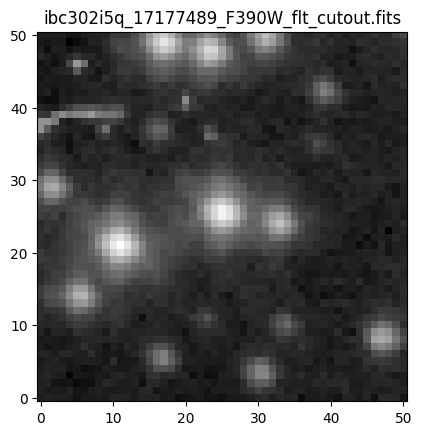

In [16]:
file = os.path.basename(filename_cutout)
plt.title(file)
plt.imshow(np.log10(cutout_URI), origin='lower', cmap='gray')
plt.show()

For a final check, we show that the dataURI cutout is the same as the dataURL cutout.

In [17]:
diff = (cutout_URI != cutout_URL).sum()
print(f'There are {diff} different pixels.')

There are 0 different pixels.


<a id="conclusions"></a>
## 7. Conclusions

Thank you for walking through this notebook. Now, you should be familiar with:

- Querying the WFC3 and WFPC2 PSF Databases for source metadata.
- Reconstructing dataURIs and dataURLs to open source cutouts.
- Downloading, extracting, loading, and plotting the cutouts.

**Congratulations, you have completed the notebook.**

<a id="add"></a>
## Additional Resources

Be sure to check out our [complimentary notebook](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/point_spread_function) on HST WFC3 PSF Modeling for a variety of science use cases (Revalski 2024).

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst) or [open a ticket on HST Notebooks](https://github.com/spacetelescope/hst_notebooks/issues).

**WFC3**
- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
    - [WFC3 PSF Website](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
    - [Chapter 6.6 UVIS Optical Performance](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-6-uvis-optical-performance)
    - [Chapter 7.6 IR Optical Performance](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-6-ir-optical-performance)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [WFC3 Instrument Science Reports](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs)
    - [WFC3 ISR 2022-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2022/WFC3-ISR-2022-05.pdf): One-Pass HST Photometry with hst1pass (Anderson 2022)
    - [WFC3 ISR 2021-12](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/ISR_2021_12.pdf): The WFPC2 and WFC3 PSF Database (Dauphin et. al 2021)

**WFPC2**
- [WFPC2 Instrument Handbook](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/legacy/wfpc2/_documents/wfpc2_ihb.pdf)
    - see Chapter 5: Point Spread Function for documentation on WFPC2's PSFs
- [WFPC2 Data Handbook](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/legacy/wfpc2/_documents/wfpc2_dhb.pdf)

**MAST**
- [MAST Website](https://archive.stsci.edu/)
- [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)
    - [MAST WFC3/WFPC2 PSF Field Descriptions](https://mast.stsci.edu/api/v0/_w_f_c3__p_s_ffields.html)
- [MAST API](https://mast.stsci.edu/api/v0/)
    - [Services](https://mast.stsci.edu/api/v0/_services.html) (Examples exist for WFC3/UVIS and WFC3/IR databases)
    - [Python Examples](https://mast.stsci.edu/api/v0/pyex.html) (Examples exist for WFC3/UVIS and WFC3/IR databases)
    - As of August 2024, the MAST API for WFPC2 PSFs has not been documented, but the `service` is called `Mast.Catalogs.Filtered.Wfpc2Psf.Uvis`.

<a id="about"></a>
## About this Notebook

**Author:** Fred Dauphin, WFC3 Instrument

**Created On:** 2024-09-11

**Updated On:** 2024-09-11

**Source:** [HST Notebooks](https://github.com/spacetelescope/hst_notebooks)

<a id="cite"></a>
## Citations

If you use `numpy`, `matplotlib`, `astropy`, or `astroquery` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 